# Xarray Dask Example Notebook optimized for terrabyte Portal use

 This notebook can be run in the micromamba default Environment or you can create your own user Environment (called tutorialEnv in the example) using:
 
`!micromamba install -y -n tutorialEnv jupyter xarray rioxarray odc-stac odc-geo pystac-client dask folium geopandas zarr jupyter-server-proxy`

and then starting a new Jupyter Environment from the portal specifying the Name of your newly created env in the  custom Environment Field

In [1]:
#!micromamba install -y -n tutorialEnv jupyter xarray rioxarray odc-stac odc-geo pystac-client dask folium geopandas zarr jupyter-server-proxy

In [1]:
import os
import time
import socket
import xarray
import rioxarray
from odc import stac as odc_stac
from odc.geo import geobox
from pystac_client import Client as pystacclient
import dask
from dask.distributed import Client
import folium
import folium.plugins as folium_plugins
import geopandas as gpd
import numpy as np

In [2]:
#for now we use the Home Folder ~
dir_out = '~/xarray-dask-tutorial'

# Stac settings 
catalog_url = 'https://stac.terrabyte.lrz.de/public/api'
collection = 'sentinel-2-c1-l2a'

# input data settings
year = 2023
resolution = 60
mgrs = 'MGRS-32UPU'
max_cloud_cover = 60
bands = ['nir', 'red']

filename_base = f'S2_y{year}_res{resolution}_median_{mgrs}.zarr'
filename = os.path.join(dir_out, filename_base)

dask_tmpdir = os.path.join(dir_out, 'scratch', 'localCluster')
dask_chunksize=1024
# from testins running without threads is the faster option 
dask_threads = 1

# Explore the STAC catalog

In [3]:
catalog = pystacclient.open(catalog_url)

# list the IDs of all STAC catalog collections
for coll in catalog.get_all_collections():
    print(coll.id)

sentinel-1-grd
modis-13a2-061
sentinel-2-c1-l1c
sentinel-3-olci-l1-efr
sentinel-2-c1-l2a
viirs-09ga-001
sentinel-2-l1c
modis-10a1-061
cop-dem-glo-90
modis-09gq-061
cop-dem-glo-30
viirs-13a1-001
sentinel-1-slc
landsat-tm-c2-l2
landsat-etm-c2-l2
sentinel-1-nrb
landsat-ot-c2-l2
modis-13q1-061
viirs-15a2h-001
sentinel-2-l2a
modis-13a3-061
modis-09ga-061


# Query data from the STAC catalog

In [4]:
query = {
    'eo:cloud_cover': {
        "gte": 0,
        "lte": max_cloud_cover
    },
    'grid:code': {'eq': mgrs}
}
mgrs = 'MGRS-32UPU'

start = f'{year}-01-01T00:00:00Z'
end = f'{year}-12-31T23:59:59Z'

resultsS2Stac = catalog.search(collections=[collection],
                               datetime=[start, end],
                               query=query)
items = list(resultsS2Stac.items())
print(f'Found {len(items)} Scenes') 

Found 54 Scenes


# Visualize the covered area

In [5]:
map = folium.Map()
layer_control = folium.LayerControl(position='topright', collapsed=True)
fullscreen = folium_plugins.Fullscreen()
style = {'fillColor': '#00000000', "color": "#0000ff", "weight": 1}

footprints = folium.GeoJson(
    gpd.GeoDataFrame.from_features([item.to_dict() for item in items]).to_json(),
    name='Stac Item footprints',
    style_function=lambda x: style,
    control=True
)

footprints.add_to(map)
layer_control.add_to(map)
fullscreen.add_to(map)
map.fit_bounds(map.get_bounds())
map

# Load the STAC items into xarray

In [6]:
cube = odc_stac.load(
    items,
    bands=bands,
    resolution=resolution,
    groupby='solar_day',
    chunks={'x': dask_chunksize, 'y': dask_chunksize},  # spatial chunking
    anchor=geobox.AnchorEnum.FLOATING  # preserve original pixel grid
)
# temporal chunking
cube = cube.chunk(chunks={'time': -1})

# write CF-compliant CRS representation
cube = cube.rio.write_crs(cube.coords['spatial_ref'].values)
cube

<xarray.Dataset>
Dimensions:      (y: 1830, x: 1830, time: 53)
Coordinates:
  * y            (y) float64 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
  * time         (time) datetime64[ns] 2023-01-06T10:24:11.024000 ... 2023-12...
    spatial_ref  int64 0
Data variables:
    nir          (time, y, x) uint16 dask.array<chunksize=(53, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(53, 1024, 1024), meta=np.ndarray>

In [7]:
cube["ndvi"]=(cube.nir - cube.red)/(cube.nir + cube.red)
cube

<xarray.Dataset>
Dimensions:      (y: 1830, x: 1830, time: 53)
Coordinates:
  * y            (y) float64 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
  * time         (time) datetime64[ns] 2023-01-06T10:24:11.024000 ... 2023-12...
    spatial_ref  int64 0
Data variables:
    nir          (time, y, x) uint16 dask.array<chunksize=(53, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(53, 1024, 1024), meta=np.ndarray>
    ndvi         (time, y, x) float64 dask.array<chunksize=(53, 1024, 1024), meta=np.ndarray>

# Define the computation

In [8]:
median = (cube.quantile(0.5, dim='time', skipna=True, keep_attrs=True)
          .rename({b: f'{b}_median' for b in list(cube.keys())}))
median

<xarray.Dataset>
Dimensions:      (y: 1830, x: 1830)
Coordinates:
  * y            (y) float64 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
    quantile     float64 0.5
Data variables:
    nir_median   (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    red_median   (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    ndvi_median  (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>

# Start the dask client
Here we are starting the dask client for scaling the computation to the available resources.  
Once started, a link to the dask dashboard will be shown which will display details on the dask computation status.

In [9]:
host = os.getenv('host')
jl_port = os.getenv('port')
#create to URL to point to the jupyter-server-proxy
dask_url = f'https://portal.terrabyte.lrz.de/node/{host}/{jl_port}'+'/proxy/{port}/status'
#dask will insert the final port choosen by the Cluster 

dask.config.set({'temporary_directory': dask_tmpdir,
                 'distributed.dashboard.link': dask_url})

#some settings to increase network timeouts and allow the dashboard to plot larger graphs
dask.config.set({'distributed.comm.timeouts.tcp': '180s',
                 'distributed.comm.timeouts.connect': '120s',
                 'distributed.dashboard.graph-max-items': 55000,
                 'distributed.deploy.lost-worker-timeout': '90s',
                 'distributed.scheduler.allowed-failures': 180,
                 })
#we set the dashboard address for dask to choose a free random port, so there is no error with multiple dasks running on same node 
client = Client(threads_per_worker=dask_threads, dashboard_address="127.0.0.1:0")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/21568/proxy/42343/status,
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/21568/proxy/42343/status,Workers: 16
Total threads: 16,Total memory: 50.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34585,Workers: 16
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/21568/proxy/42343/status,Total threads: 16
Started: Just now,Total memory: 50.00 GiB
Comm: tcp://127.0.0.1:33771,Total threads: 1
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/21568/proxy/43495/status,Memory: 3.12 GiB
Nanny: tcp://127.0.0.1:44839,


# Start the computation
Here the actual computation is started and the result written to the output file.  
Check the dask dashboard for computation progress.

In [10]:
%%time
#ignore invalid value encountered in divide warning (ndvi divide by zero)
delayed = median.to_zarr(filename, mode='w', compute=False, consolidated=True)
dask.compute(delayed)

/dss/dsshome1/lxc0C/di76qir/.local/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/dss/dsshome1/lxc0C/di76qir/.local/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/dss/dsshome1/lxc0C/di76qir/.local/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/dss/dsshome1/lxc0C/di76qir/.local/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 41.1 s, sys: 3.55 s, total: 44.6 s
Wall time: 2min 35s


(None,)

In [11]:
client.cluster.close()
time.sleep(5)
client.close()

# Load and Visualize the result from File

In [12]:
result = xarray.open_zarr(filename)
result

<xarray.Dataset>
Dimensions:      (y: 1830, x: 1830)
Coordinates:
    quantile     float64 ...
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
  * y            (y) float64 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
Data variables:
    ndvi_median  (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    nir_median   (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    red_median   (y, x) float64 dask.array<chunksize=(1024, 1024), meta=np.ndarray>

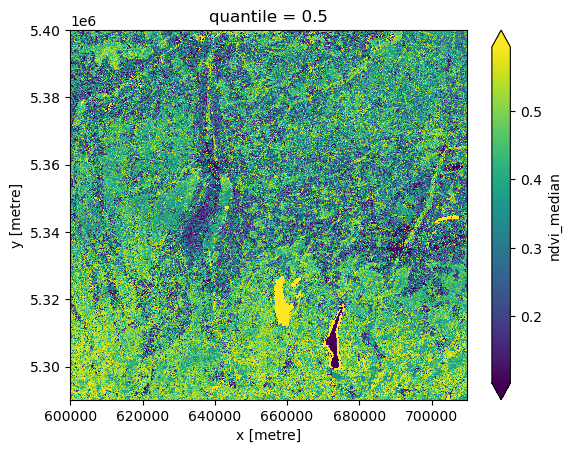

In [13]:
result.ndvi_median.plot(robust=True)

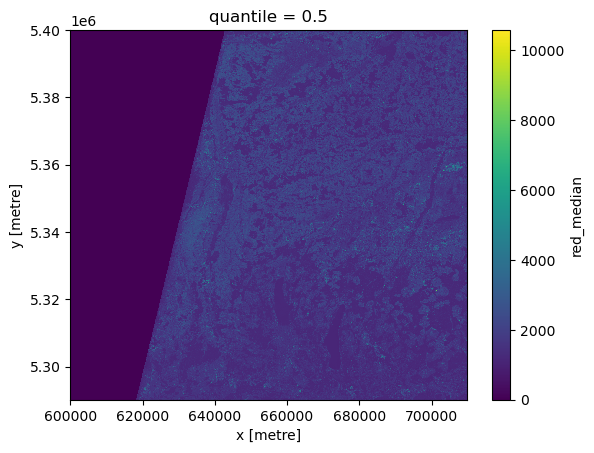

In [14]:
result['red_median'].plot()

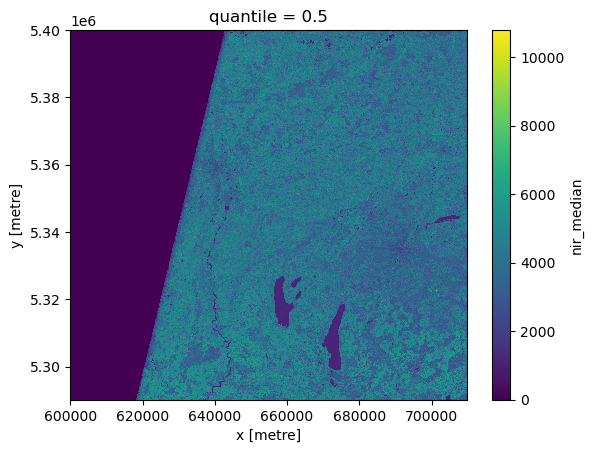

In [16]:
result['nir_median'].plot()